<a href="https://colab.research.google.com/github/iamthedoan/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-06-07 17:51:05--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-06-07 17:51:06 (6.36 MB/s) - ‘names.txt’ saved [228145/228145]



In [5]:
words = open('names.txt', 'r').read().splitlines()
print(words[:5])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


**E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2**

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [21]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


Hyperparameters:
- number of neurons
- embedding dimensionality
- block size
- number of training runs
- learning rate
- learning rate decay
- batch size

In [22]:
# hyperparameters

emb_dim = 20
num_neuron = 300
input = block_size * emb_dim
batch_size = 128 # can increase batch_size for lower loss but don't want to overfit

lr = 0.1

l1 = 0.125
l2 = 0.125

# emb_dim: 10 -> 15, 2.136 --> 2.076; decreased loss
# num_neuron: 200 -> 300, 2.136 --> 2.133; no real change
# batch_size: 32 -> 48, 2.136 --> 2.12; decreased loss

# emb_dim: 15, num_neuron: 300, batch_size: 64; 2.053; decreased loss
# emb_dim: 20, num_neuron: 300, batch_size: 64; 2.018; decreased loss

# rate of decay (with line above), lr = 0.1 if i < 50000 else 0.01; 2.049; decreased loss
# rate of decay, lr = 0.1 first 100000, 0.01 next 100k, 0.001 last 100k; 2.082

# work on rate of decay and LR

# regularization: 0.2 --> 2.012
# 0.15 --> 2.011
# 0.1 --> 2.013
# 0.125 --> 2.011

In [23]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_dim), generator=g) # 27 chars, 10 embeddings?
W1 = torch.randn((input, num_neuron), generator=g) #  30 is num of inputs (3 (context) * 10 (embeddings)), 200 is number of neurons
b1 = torch.randn(num_neuron, generator=g) # biases must match num neurons
W2 = torch.randn((num_neuron, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

lri = []
lossi = []
stepi = []

In [109]:
sum(p.nelement() for p in parameters) # number of parameters in total

26967

In [24]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # 32 is batch size

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, input) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # regularization
  loss += l1 * (W1**2).mean() + l2 * (W2**2).mean()
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

  if i % 10000 == 0:
    print(f"batch {i} with loss {loss.item()} at lr {lr}")
#print(loss.item())

batch 0 with loss 31.794038772583008 at lr 0.1
batch 10000 with loss 2.7055623531341553 at lr 0.1
batch 20000 with loss 2.4192254543304443 at lr 0.1
batch 30000 with loss 2.2750725746154785 at lr 0.1
batch 40000 with loss 2.6556453704833984 at lr 0.1
batch 50000 with loss 2.174666404724121 at lr 0.1
batch 60000 with loss 2.2229044437408447 at lr 0.1
batch 70000 with loss 2.2763426303863525 at lr 0.1
batch 80000 with loss 2.1773993968963623 at lr 0.1
batch 90000 with loss 2.1867451667785645 at lr 0.1
batch 100000 with loss 2.3095030784606934 at lr 0.01
batch 110000 with loss 2.0327532291412354 at lr 0.01
batch 120000 with loss 2.300105571746826 at lr 0.01
batch 130000 with loss 2.196686267852783 at lr 0.01
batch 140000 with loss 2.2104456424713135 at lr 0.01
batch 150000 with loss 2.039677381515503 at lr 0.01
batch 160000 with loss 2.003998041152954 at lr 0.01
batch 170000 with loss 2.0074737071990967 at lr 0.01
batch 180000 with loss 1.966333270072937 at lr 0.01
batch 190000 with loss 

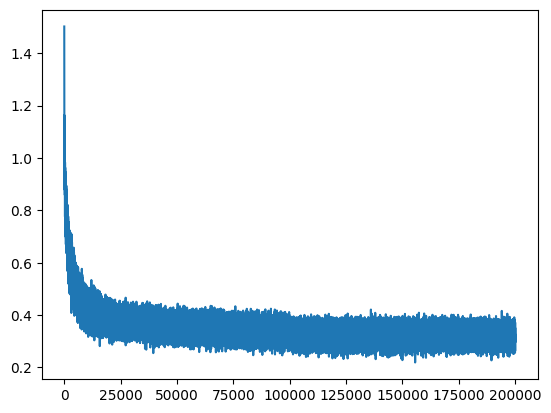

In [25]:
plt.plot(stepi, lossi)

In [26]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, input) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

# lowest loss achieved: 2.0063

tensor(1.9862, grad_fn=<NllLossBackward0>)

In [27]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, input) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0914, grad_fn=<NllLossBackward0>)

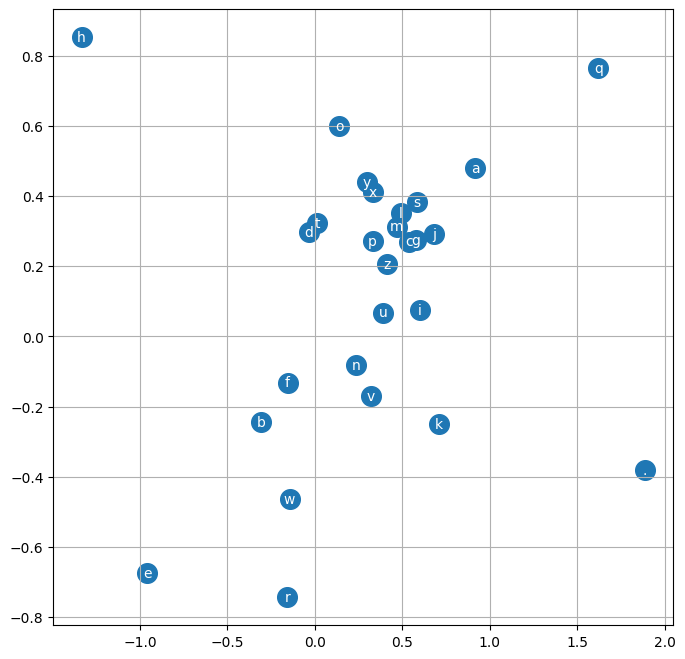

In [28]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [29]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

montay.
yazmiee.
madyn.
alarithan.
endrien.
adelynneliia.
mikola.
edelina.
anarayat.
kohlan.
caysau.
vigdhithest.
jairenelipan.
paiffon.
kavdor.
yahleyeh.
yuma.
myshelde.
halina.
yansum.


**E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?**

In [47]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [55]:

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # 27 chars, 10 embeddings?
W1 = torch.randn((30, 200), generator=g) #  30 is num of inputs (3 (context) * 10 (embeddings)), 200 is number of neurons
# b1 = torch.randn(200, generator=g) # biases must match num neurons
b1 = torch.zeros(200)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True


In [32]:
b1.shape

torch.Size([300])

In [56]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)

# fills tensor with values drawn from uniform distribution
torch.nn.init.uniform_(logits,0,1)
loss = F.cross_entropy(logits, Ytr)
print(f"training loss: {loss.item()}")

# dev loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
torch.nn.init.uniform_(logits,0,1)
loss = F.cross_entropy(logits, Ydev)
print(f"dev loss: {loss.item()}")

training loss: 3.3350651264190674
dev loss: 3.3353378772735596


In [57]:
# tuning intialization

# fills tensor with normal distribution
torch.nn.init.normal_(C, 0, 0.01)
torch.nn.init.normal_(W1, 0, 0.01)
torch.nn.init.normal_(b1, 0, 0.01)
torch.nn.init.normal_(W2, 0, 0.01)
torch.nn.init.normal_(b2, 0, 0.01)


ix = torch.randint(0, Xtr.shape[0], (32,))

# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)

loss = F.cross_entropy(logits, Ytr)
print(f"training loss: {loss.item()}")

#

training loss: 3.296443462371826
